<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/Jupyter/Equalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [222]:
import logging as logg
from numba import njit

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

from optic.comm.modulation import modulateGray, GrayMapping
from optic.dsp.core import pnorm, upsample, firFilter, pulseShape, signal_power, phaseNoise, decimate, resample, symbolSync
from optic.dsp.equalization import edc
from optic.models.devices import iqm, coherentReceiver, pdmCoherentReceiver, basicLaserModel
from optic.models.channels import linearFiberChannel
from optic.comm.metrics import fastBERcalc
from optic.utils import parameters, dBm2W
from optic.plot import pconst, eyediagram, plotPSD
from optic.models.tx import simpleWDMTx

# Equalização

Neste notebook iremos explorar os próximos blocos na cadeia de algoritmos DSP que são dois equalizadores lineares que compensam os efeitos da dispersão cromática (CD) e da dispersão do modo de polarização (PMD) que são implementados na maioria dos receptores ópticos digitais coerentes.

Em sistemas ópticos digitais coerentes, a compensação CD é completamente deixada para o domínio digital. As vantagens dessa escolha são diversas, como a redução das perdas de inserção causadas pelos módulos ópticos de compensação de CD e a facilitação do projeto e gerenciamento do sistema. 

#### Equalização estática - Compensação CD:

Nos receptores ópticos digitais coerentes, o CD é compensado por filtros estáticos aplicados separadamente aos sinais das duas orientações de polarização. Como CD é praticamente invariante no tempo e independente da polarização, os filtros correspondentes às duas orientações de polarização possuem os mesmos coeficientes.

#### Equalização adaptativa - Compensação PMD:

Ao contrário da abordagem estática usada para compensação CD, a compensação PMD requer equalizadores que sejam capazes de atualizar adaptativamente seus coeficientes para rastrear variações na resposta de frequência do canal, causadas por perturbações mecânicas na geometria da fibra ou oscilações de temperatura. Além disso, como os canais de polarização se acoplam durante a transmissão por fibra, são necessárias arquiteturas com múltiplas entradas e múltiplas saídas (MIMO). Como benefício colateral, a equalização adaptativa também compensa efeitos lineares residuais, como o CD que sobrou do equalizador estático ou filtragem de banda estreita em interruptores seletivos de comprimento de onda.

### 5.1 Static Equalization

O módulo de compensação CD é o primeiro a ser implementado no receptor após o front-end e a compensação de suas imperfeições. Como o CD se comporta bem no tempo e afeta igualmente ambas as orientações de polarização, os filtros de compensação CD são estáticos, ou seja, seus coeficientes não variam com o tempo. As questões mais relevantes da compensação CD estão relacionadas com a implementação do hardware e a sua complexidade e consumo de energia.

A primeira tarefa para implementar filtros de compensação CD é dimensionar seus parâmetros levando em consideração as propriedades do canal óptico. Naturalmente, o design do equalizador está diretamente relacionado à propagação do atraso do canal. Uma aproximação para o *delay spread* do CD é dada por: 

$$\Delta T=|D|L\Delta\lambda=2\pi|\beta_{2}|L\Delta_{f}$$

onde $D$ é o parâmetro de dispersão da velocidade de grupo (GVD), $L$ é o comprimento da fibra, $\Delta \lambda$ e $\Delta f$ são as larguras de banda espectrais em comprimento de onda e frequência, e $\beta_{2}$ é a segunda derivada da constante de propagação $\beta$ em relação à frequência angular $\omega$. Se o sinal recebido for amostrado a uma taxa de amostragem $T_{Sa}$ (período de amostragem), o *delay spread* no número de amostras é dado por:

$$N_{\mathrm{DS}}=\left[\frac{\Delta T}{T_{S a}}\right]=\left[\frac{2\pi\,|\beta_{2}|L\,\Delta f}{T_{S a}}\,\right]$$

Assumindo modelagem de pulso de Nyquist com largura de banda mínima ($\Delta f\,\approx\,R_{s}$) e uma taxa de sobreamostragem $M/K\ (T_{S a}=K/(M R_{S}))$, então:

$$N_{\mathrm{DS}}\approx\left[2\pi|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

Esperamos que o comprimento mínimo do equalizador CD seja proporcional ao $N_{DS}$, mas o valor exato depende de muitos aspectos, particularmente da forma do pulso e do filtro anti-aliasing. Uma expressão empírica para esse comprimento mínimo, validada para diversos formatos de pulso, é apresentado como:

$$N_{\mathrm{CD}}\approx\left[6.67|\beta_{2}|L R_{s}^{2}(M/K)\right]$$

### 5.1.1 Equalização no domínio da frequência

A depender das características do link o equalizador CD pode ter centenas ou milhares de *taps*, dependendo da taxa de amostragem e comprimento do link. Portanto, a equalização no domínio da frequência é geralmente preferida para reduzir a complexidade. Assumindo uma frequência de Nyquist $f_{N}\,=\,1/(2T_{S a})$, os coeficientes de um equalizador CD no domínio da frequência de tamanho NFFT são facilmente obtidos a partir da resposta de frequência CD dada por:

$$H_{\mathrm{CD}}[n]=e^{-j\frac{\pi\lambda^{2}D L}{c}\Big(n\frac{2f_{N}}{N_{\mathrm{FFT}}}\Big)^{2}},\ \ \ -\frac{N_{\mathrm{FFT}}}{2}\le n\le\ \frac{N_{\mathrm{FFT}}}{2}-1$$

In [2]:
def freqHCD(Fc, Fs, D, NFFT, L):
    """

    Retorna a resposta em frequência da dispersão cromática,
    de acordo com os parâmetros da simulação.

    Args:
        Fc (float): frequência central.
        Fs (float): frequência de amostragem.
        D (int): dispersão cromática [ps/nm/km]
        NFFT (int): tamanho da FFT.
        L (int): comprimento do enlace.

    Returns:
        np.array: resposta em frequência para dispersão cromática.
    """

    # parâmetros: 
    
    c = 299792458   # velocidade da luz no vacuum
    λ = c/Fc        # comprimento de onda

    beta2 = -(D * λ**2) / (2 * np.pi * c)

    omega = 2 * np.pi * Fs * np.fft.fftfreq(NFFT)

    #Tsa = 1/oversampling*1/Rs
    return np.exp(-1j * beta2/2 * omega**2 * L)

### Respostas de magnitude e fase de um filtro de compensação de dispersão $H_{CD}[n]$

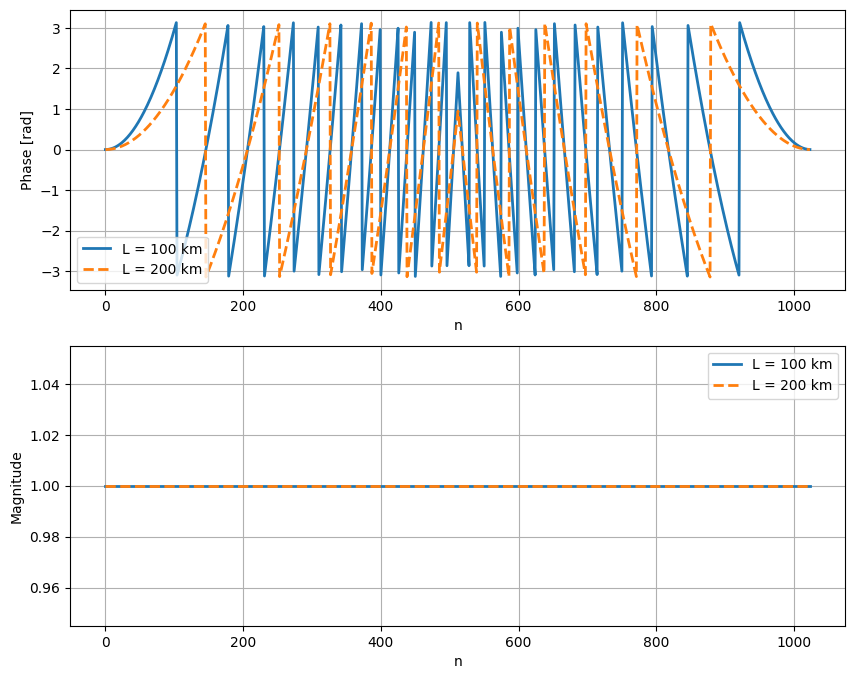

In [3]:
NFFT = 1024     # comprimento do filtro
Rs   = 30e9     # taxa de símbolos
D    = 17e-6    # parâmetro de dispersão ps/(nm*km)
SpS  = 2        # amostras por símbolo
Fc   = 193.1e12
Fs   = SpS*Rs

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# phase
axs[0].plot(np.angle(freqHCD(Fc, Fs, D, NFFT, L=200e3)), label='L = 100 km', linewidth = 2)
axs[0].plot(np.angle(freqHCD(Fc, Fs, D, NFFT, L=100e3)), '--', label='L = 200 km', linewidth = 2)
axs[0].set_ylabel('Phase [rad]')
axs[0].set_xlabel('n')
axs[0].legend()
axs[0].grid()

# Magnitude
axs[1].plot(np.abs(freqHCD(Fc, Fs, D, NFFT, L=100e3)), label='L = 100 km', linewidth = 2)
axs[1].plot(np.abs(freqHCD(Fc, Fs, D, NFFT, L=200e3)), '--', label='L = 200 km', linewidth = 2)
axs[1].set_ylabel('Magnitude')
axs[1].set_xlabel('n')
axs[1].legend()
axs[1].grid()

Como esperado, o diagrama de amplitude é constante, indicando um filtro passa-tudo, enquanto o diagrama de fases mostra um perfil parabólico. Quanto maior for a dispersão acumulada, mais íngreme será o perfil parabólico. 

Uma dificuldade na implementação da compensação CD no domínio da frequência é que a equalização é realizada em blocos. Quando a equalização é realizada em blocos individuais, não é possível cancelar a interferência intersimbólica (ISI) nas bordas do bloco. Além disso, a equalização no domínio da frequência envolve o cálculo da transformada discreta de Fourier (DFT) do bloco, a multiplicação pelos coeficientes do filtro e o cálculo da transformada discreta inversa de Fourier (IDFT), geralmente implementada por transformadas rápidas (inversas) de Fourier (FFTs/IFFTs). 

Este processo corresponde a uma convolução cíclica do bloco de sinal pelos coeficientes do filtro, o que causa aliasing no tempo. A recuperação da convolução linear da sequência recebida pelos coeficientes do filtro, a partir da convolução cíclica em blocos, pode ser alcançada de duas maneiras.

A primeira é inserir intervalos de guarda ou prefixos cíclicos entre os blocos, o que desperdiça largura de banda de transmissão. A segunda solução são os métodos de *overlap* e adição de *overlap*, que não consomem largura de banda, mas aumentam a complexidade do DSP. Em sistemas de comunicação óptica, os métodos baseados em *overlap* são geralmente preferidos. 

### Método Overlap-Save

<br>
<center>
    <img src="https://i.postimg.cc/QC1yzz31/Screenshot-from-2024-04-22-18-59-51.png">
</center>
<br>

O método *overlap-save* é descrito na figura acima. Uma sequência de amostras entra continuamente no receptor. Esta sequência é dividida em blocos de igual comprimento para processamento no domínio da frequência, de tal forma que o bloco $I_n$ se sobrepõe aos blocos $I_{n−1}$ e $I_{n+1}$. Após a FFT, multiplicação por coeficientes do filtro, e IFFT, o bloco de saída $O_n$ é obtido. Se $I_n$ for equalizado independentemente, o ISI gerado pelos os símbolos vizinhos nas bordas de $O_n$ ficam sem compensação e a convolução cíclica causa aliasing no tempo. Portanto, a sequência de saída é recuperada preservando a porção central de $O_n$ e descartando suas arestas. Esta abordagem é repetida sequencialmente de forma a evitar qualquer perda de informação.

O método *overlap-save* têm dois parâmetros importantes, o tamanho da FFT, $N_{FFT}$, e o tamanho do *overlap*, $N_{Overlap}$. O valor mínimo de $N_{Overlap}$ é dado pelo comprimento mínimo do equalizador ($N_{CD}$), enquanto o NFFT é normalmente ajustado para minimizar a complexidade. O número de multiplicações por símbolo exigidas pelos métodos de *overlap* vista em [2] pode ser calculado como:

$$N_{\mathrm{mult}}=\frac{N_{\mathrm{FFT}}\left[6\cdot C\cdot1\mathrm{og}_{2}(N_{\mathrm{FFT}})+3\right]}{N_{\mathrm{FFT}}-N_{\mathrm{Overlap}}+1}$$

Onde $C$ é uma constante relacionada à implementação da FFT. Para implementações de base 2 (tamanho de FFT igual a uma potência de 2) $C = 1/2$, e para implementações de base 4 (tamanho de FFT igual a uma potência de 4) $C = 3/8$.

### Implementação do método Overlap-and-Save

Nesta implementação estou seguindo a referência descrita no livro [Processamento Digital de Sinais Projeto e Análise de Sistemas. 2º Ed.](https://www.amazon.com.br/Processamento-Digital-Sinais-Projeto-Sistemas-ebook/dp/B016P88HNM) que aborda uma implementação clássica que descarta apenas uma das bordas de cada bloco.

In [4]:
def overlap_save(x, h, NFFT):
    """

    Implementa convolução usando o método FFT de sobreposição e salvamento
    (overlap-and-save).

    Args:
        x (np.array): sinal de entrada
        h (np.array): coeficientes do filtro
        NFFT (int): o tamanho da FFT deve ser maior que a ordem do filtro.
                    De preferência utilize valores em potência de 2 para 
                    se aproveitar da transformada rápida de Fourier.

    Returns:
        y_out (np.array): sinal de saída filtrado.
    
    Raises:
        ValueError: caso o tamanho da NFFT seja menor que o comprimento do filtro.
    
    Referências:
        [1] Processamento Digital de Sinais Paulo S. R. Diniz Eduardo A. B. da Silva Sergio L. Netto
        Projeto e Análise de Sistemas. 2º Ed.
    """
    
    K = len(h)
    L = len(x)

    if NFFT < K:
        raise ValueError('NFFT deve ser maior ou igual ao comprimento do filtro')
    
    # determina o atraso da filtragem FIR
    delay = (K - 1) // 2
    
    overlap = K - 1

    # obtem a quantidade de blocos de entrada
    B = np.ceil((L + overlap) / (NFFT - K + 1)).astype(int)

    # realiza o zero pad para K-1 amostras no inicio do sinal 
    # e compensa o comprimento do último bloco
    x = np.pad(x, (overlap, NFFT), mode='constant', constant_values=0+0j)

    # preenche h com zeros até o comprimento NFFT
    h = np.pad(h, (0, NFFT - K), mode='constant', constant_values=0+0j)

    # buffer para os blocos de entrada
    N = np.zeros((NFFT + delay,), dtype='complex')

    # sinal de saída filtrado
    y_out = np.zeros((B * (len(N) - overlap)), dtype='complex')

    for m in range(B):
        
        step = m * (NFFT - overlap)
        
        # janela deslizante que extrai os blocos de entrada de comprimento NFFT.
        N = x[step:step+NFFT]

        H = np.fft.fft(h)
        X = np.fft.fft(N)

        # obtém a convolução circular de cada bloco com a responta ao impulso do filtro.
        y = np.fft.ifft(X * H)

        # obtém as amostras válidas descartando a sobreposição K-1.
        y_out[step:step+(NFFT-overlap)] = y[overlap:]

    return y_out[delay:delay+L]

### Transmissor
**geração de sinal de polarização única**

In [17]:
# Transmitter parameters
M = 16                   # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rrc'       # Pulso a ser utilizado
Rs = 32e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 8                 # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 300          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]
paramFiber.Fc = 193.1e12    # Hz

### Core simulation

Potência média do sinal óptico modulado [mW]: 1.205 mW
Potência média do sinal óptico modulado [dBm]: 0.812 dBm


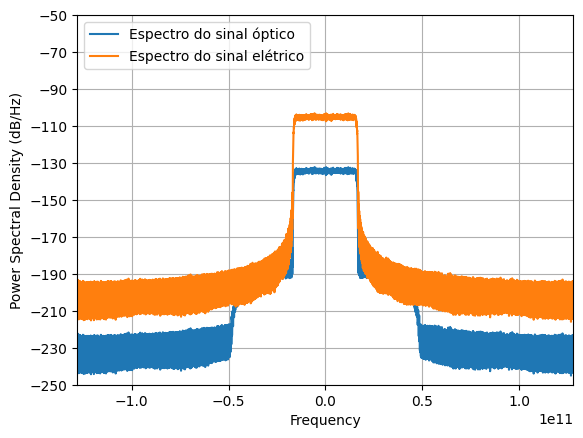

In [18]:
plotPSD = True

# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

symbTx = modulateGray(bitsTx, M, constType)
symbTx = pnorm(symbTx) # symbol power normalization

symbolsUp = upsample(symbTx, SpS)

if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rrc":
    pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    plt.psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
    plt.legend(loc='upper left');
    plt.xlim(-SpS*Rs/2,SpS/2*Rs);

### Simula um front-end do receptor coerente sujeito a ruído de fase do laser

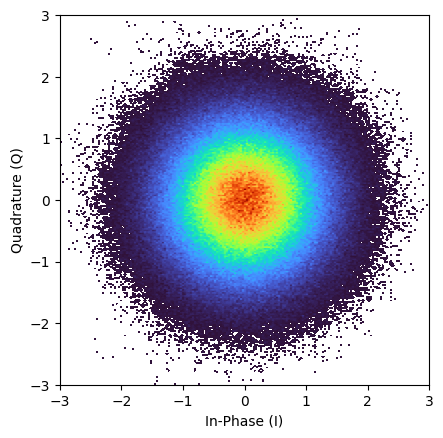

In [19]:
# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# parâmetros do receptor
B = 32e9            # banda do receptor em Hz
Plo_dBm  = 10       # potência do oscilador local
Δf_lo    = 0        # desvio de frequência do oscilador local
ϕ_lo     = 0        # fase do oscilador local
lw       = 100      # laser linewidth Hz

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# sinal na saída do front-end do receptor coerente
sigRx_ = coherentReceiver(sigRxo, sigLO)
pconst(sigRx_, R=3);

### Constelação após filtro casado

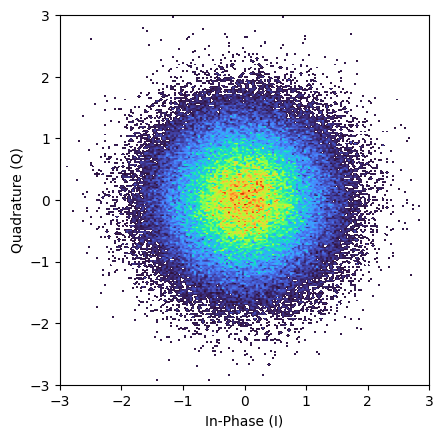

In [20]:
# filtro casado
sigRx = firFilter(pulse, sigRx_)
pconst(sigRx[0::SpS], R=3);

# downsampling to 2 samples/symbol
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

### Compensa a dispersão cromática

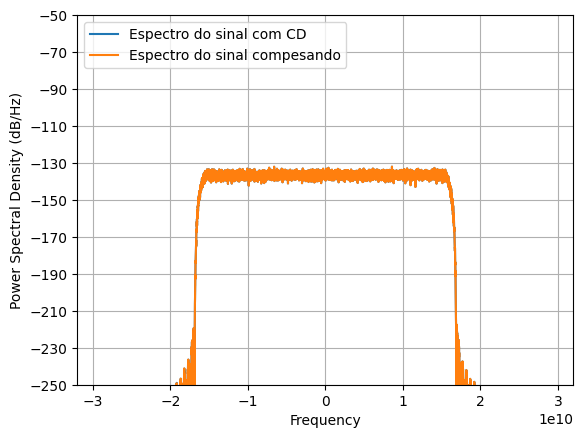

In [21]:
# obtem a resposta em frequência da dispersão cromática.
HCD = freqHCD(paramFiber.Fc, 2*Rs, paramFiber.D*1e-6, NFFT=512, L=paramFiber.L*1e3)

# define o tamanho da FFT
NFFT = 1024
sigRxEDCout = overlap_save(sigRx, np.fft.fftshift(np.fft.ifft(HCD)), NFFT)

plt.figure();
plt.ylim(-250,-50);
plt.psd(sigRx, Fs=2*Rs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal com CD')
plt.psd(sigRxEDCout, Fs=2*Rs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal compesando')
plt.legend(loc='upper left');
plt.xlim(-Rs,Rs);

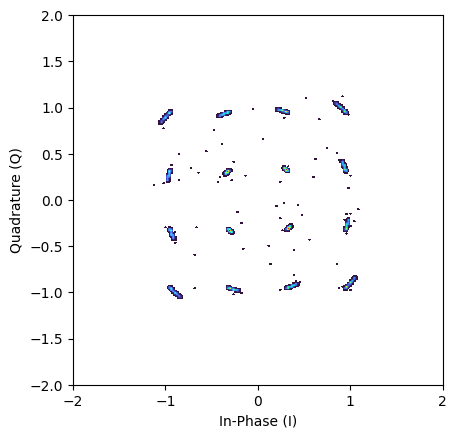

In [22]:
# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = 2
paramDec.SpS_out = 1
sigRxEDCout = decimate(sigRxEDCout.reshape(-1,1), paramDec).reshape(-1,)

discard = 400
ind = np.arange(discard, sigRxEDCout.size-discard)

sigRxEDCout = pnorm(sigRxEDCout)
pconst(sigRxEDCout, R=2);

# plt.figure()
# plt.plot(sigRxEDCout.real,'.')

### 5.2.1 Fundamentals of Adaptive Equalization

Tomando o modelo canônico de canal em tempo discreto. Um sinal transmitido $s[k]$ está sujeito a um sistema linear com resposta ao impulso $h[k]$, produzindo $r[k]$. Depois disso, $r[k]$ é ainda contaminado pelo ruído gaussiano branco aditivo (AWGN) $\eta[k]$, gerando o sinal recebido $x[k]$

$$x[k]\ =\ \sum_{i=-\infty}^{\infty}\ (\,h[i]\,s[k-i]\,)+\eta[k]=h[k]*s[k]+\eta[k]$$

<center>
    <img src=https://i.postimg.cc/Gm98K8ML/Screenshot-from-2024-05-22-08-18-31.png>
</center>

Ainda se considerarmos o atraso $d$ do canal podemos reescrever como:

$$x[k]~=~h[d]\,s[k-d]+\sum_{i=-\infty,i\neq d}^{\infty}\,(\,h[i]\,s[k-i]\,)+\eta[k]$$

Assim podemos visualizar que o sinal recebido $x[k]$ pode ser expresso como o sinal transmitido $s[k]$, atrasado por $d$ amostras e escalonado por $h[d]$, adicionado ao termo de ruído $\eta[k]$ e ao termo ISI (Interferência Intersimbólica). 

No receptor, assumimos que $x[k]$ é processado por um filtro transversal linear com resposta ao impulso finito $w^*[k]$ de comprimento $N$,produzindo o sinal equalizado $y[k]$

$$y[k]~=~\sum_{i=0}^{N-1}\left(w^{*}[i]\,x[k-i]\right)=w^{H}\,{\bf x}[k]$$

Onde $N$ é o comprimento do equalizador, $\mathbf{w}=\left[w_{0}\;\;w_{1}\;.\;.\;.\;w_{N-1}\right]^{T}$ são os coeficientes do filtro, ${\bf x}[k]\;=\;[\:{x}[k]\;x[k\:-\:1]\:\ldots\:{x}[k\:-\:N\:+\:1\:]\:]^{T}$ é o vetor de sinal recebido, $(.)^∗$ é o operador conjugado complexo e $(.)^H$ é o operador de transposição Hermitiano.

Uma primeira tentativa de mitigar a ISI pode ser realizada pelo chamado equalizador de zero forçado (ZF). Assumindo transmissão sem ruído, ou seja, $\eta = 0$, o sinal equalizado $y[k]$ pode ser dado em termos da resposta combinada $c[k]$ do canal e do equalizador $c[k]=\,h[k]\ast w^*[k]$

$$y[k]~=~\sum_{i=-\infty}^{\infty}\,c[i]\,s[k-i]\,=\,c[k]\ast s[k]$$

Podemos definir o critério de equalização perfeita como:

$$y[k]\,=\,\alpha\,s[\,k-d\,]\,\,,\,\,\,\,\,\alpha\in\mathbb{R},$$

Onde $\alpha$ é um termo de ganho (atenuação ou amplificação) e $d$ é um atraso arbitrário. O sinal é considerado equalizado se recuperar o sinal transmitido, mesmo que seja multiplicado por uma constante ou atrasado no tempo. Portanto, existem em princípio infinitas soluções de equalização possíveis, cada uma correspondendo a um determinado atraso e termo de amplificação. Assim, visando a equalização perfeita, o equalizador $w[k]$ tenta aproximar-se o mais próximo possível de uma resposta combinada

$$c[k]\,\,=\,\,\alpha\,\delta\left[\,k\,-\,d\,\right]$$

Onde $\delta[k]$ é o delta de Kronecker. Isso é chamado de equalizador ZF porque força a zerar os coeficientes de $c[k]$ que não correspondem ao atraso $d$. No entanto, a equalização ZF raramente é implementada em sistemas de comunicação por duas razões principais. Primeiro, negligencia a presença de ruído e, conseqüentemente, amplifica os componentes de ruído que aparecem nas proximidades de zeros na resposta de frequência do canal. Em segundo lugar, requer o uso de um filtro de resposta de impulso infinito (IIR) para mitigação completa de ISI em canais de resposta de impulso finito (FIR).

Uma alternativa ao equalizador ZF, que é mais adequado para canais seletivos de frequência com ruído, é minimizar uma certa função de custo do erro quadrático médio (MSE).

$$J_{\mathrm{MSE}}=E\left\{|s[k-d]-y[k]|^{2}\right\}\ =\ E\left\{|e[k]|^{2}\right\}$$

Onde $d$ é um atraso arbitrário. A Equação acima afirma que qualquer solução que recupere o sinal original $s[k − d]$ é válida, mesmo que seja atrasada por $d$ amostras. A escolha de $d$ pode afetar o desempenho de equalizadores práticos (comprimento finito). Como veremos mais tarde, os sistemas ópticos escolhem $d$ de modo a ter os coeficientes do equalizador razoavelmente equilibrados em torno do centro. Se tomarmos $d = 0$

$$J_{\mathrm{MSE}}=\,E\,\left\{\left(s[k]-\mathbf{w}^{H}\mathbf{x}[k]\right)\left(s[k]-\mathbf{w}^{H}\mathbf{x}[k]\right)^{*}\right\}$$
$$=E\left\{|s|k||^{2}-s[k]\mathbf{x}[k]^{H}\mathbf{w}-\mathbf{w}^{H}\mathbf{x}[k]s^{*}[k]+\mathbf{w}^{H}\mathbf{x}[k]\mathbf{x}^{H}[k]\mathbf{w}\right\}$$
$$=E\left\{|s[k]|^{2}\right\}-E\left\{s[k]{\bf x}[k]^{H}\right\}{\bf w}-{\bf w}^{H}E\left\{{\bf x}[k]s^{*}[k]\right\}+{\bf w}^{H}E\left\{{\bf x}[k]{\bf x}^{H}[k]\right\}{\bf w}$$

Onde $\sigma_{s}^{2}\;=\;E\left\{|s[k]|^{2}\right\}$ é a potência de $s[k]$, $\mathbf{p}\ =\ E\left\{\mathbf{x}[k]s^{*}[k]\right\}$ é o vetor de correlação de $s[k]$ e $\mathbf{x}[k]$, e $\mathrm{R_{x}}\,=\,E\left\{\mathrm{x}[k]{\bf x}^{H}[k]\right\}$ como sendo a matriz de correlação de $\mathbf{x}[k]$. Assim podemos reescrever como:

$$J_{\mathrm{MSE}}=\sigma_{s}^{2}-{\bf p}^{H}{\bf w}-{\bf w}^{H}{\bf p}+{\bf w}^{H}{\bf R}_{\bf x}{\bf w}$$

O gradiente do $J_{MSE}$ é obtido diferenciando em relação aos coeficientes do filtro $\bf w$

$$\nabla J_{\mathrm{MSE}}=\frac{\partial}{\partial{\bf w}}\left\{\sigma_{s}^{2}-{\bf p}^{H}{\bf w}-{\bf w}^{H}{\bf p}+{\bf w}^{H}{\bf R}_{\bf x}{\bf w}\right\}$$

$$=-2\mathbf{p}+2\mathbf{R_{x}}\mathbf{w}$$

Portanto, $J_{\mathrm{MSE}}$ é minimizado para:

$${\bf w}_{o p t}={\bf R}_{\bf x}^{-1}{\bf p}$$

que é a conhecida solução do filtro Wiener. Em aplicações práticas, os valores exatos de $\bf Rx$ e $\bf p$ geralmente não estão disponíveis. Alternativamente, é comum recorrer ao algoritmo gradiente descendente para encontrar o pesos de filtro ideais. O algoritmo gradiente descendente é um algoritmo iterativo que estima o gradiente do erro após cada iteração. Um gradiente positivo para um peso de filtro $w_i$ indica que o erro aumenta com um aumento em $w_i$ e, portanto, $w_i$ deve ser reduzido. Por outro lado, um gradiente negativo indica que o erro diminui com o aumento de $w_i$ e, neste caso, $w_i$ deve ser aumentado. Seguindo esse raciocínio, o algoritmo gradiente descendente atualiza os pesos do filtro como:

$$\mathbf{w}[k]=\mathbf{w}[k-1]-\mu\nabla J_{\mathrm{MSE}}$$

onde $\mu$ é o tamanho do passo. Os coeficientes de filtro $\mathbf{w}$ tornam-se dependentes de $k$ conforme $\mathbf{w}[k] = [w_{0}[k]~w_{1}[k]~...~w_{N-1}[k]]^{T}.$ Porém, assim como $\bf Rx$ e $\bf p$ não estão disponíveis para cálculo da solução de Wiener, eles também não estão disponíveis para cálculo de $\nabla J_{\mathrm{MSE}}$ no algoritmo gradiente descendente. Em vez disso, uma abordagem comum e aplicar o método estocástico de descida gradiente, que aproxima $\bf Rx$ e $\bf p$ por valores instantâneos $\mathbf{R}_{\mathbf{X}}\approx\mathbf{x}[k]\mathbf{x}[k]^{H}$ e $\mathbf{p}\approx\mathbf{x}[k]s^{*}[k]$

$$\nabla J_{\mathrm{MSE}}[k]=2\mathbf{x}[k]\mathbf{x}^{H}[k]\mathbf{w}[k-1]-2\mathbf{x}[x]s^{*}[k]$$
$$=-2\mathbf{x}[k]e^{*}[k].$$

Onde $e[k]=s[k]-{\bf w}^{H}[k-{\bf1}]{\bf x}[k]=s[k]-{\bf y}[k]$. Usando a expressão derivada para $\nabla J_{\mathrm{MSE}}[k]$, o algoritmo descendente de gradiente estocástico atualiza os coeficientes do filtro como:

$${\bf w}[k]={\bf w}[k-1]+\mu{\bf x}[k]e^{*}[k]$$

Este é conhecido como algoritmo de mínimos quadrados médios (LMS). O tamanho do passo $\mu$ é geralmente selecionado empiricamente para equilibrar o excesso de erro e a velocidade de convergência. Um $\mu$ grande aumenta a velocidade de convergência, mas pode levar a grandes erros excessivos (entre sinais transmitidos e equalizados) ou problemas de convergência. Por outro lado, um pequeno $\mu$ reduz a velocidade de convergência e pode levar a um mau rastreamento do canal em ambientes que variam no tempo. O algoritmo LMS é a base para a maioria dos algoritmos de rastreamento de polarização e demultiplexação de sinal usados ​​em sistemas ópticos digitais coerentes.

### Implementação e exemplos de equalização linear com LMS

Para implementação do filtro de mínimos quadrados médios consulte o pseudo código [aqui](https://en.wikipedia.org/wiki/Least_mean_squares_filter), ou consulte o livro [Adaptive Filtering Algorithms and Practical Implementation](https://link.springer.com/chapter/10.1007/978-0-387-68606-6_13) para mais detalhes. Além disso você deve considerar a compensação do atraso do filtro FIR em sua implementação. 

Quando atualizamos os coeficientes do filtro estamos implicitamente realizando um produto interno. Para que a atualização preserve as propriedades corretas do espaço vetorial complexo, devemos usar o conjugado complexo de $\bf x$ para realizar a filtragem de sinais complexos

In [50]:
def lms(u, d, taps, mu):
    """ Least mean squares (LMS)
    
    Simples implementação do algoritmo LMS para filtragem adaptativa.

    Args:
        u (np.array): sinal de entrada unidimensional 
        d (np.array): sinal de referência unidimensional
        taps (int)  : número de coeficientes do filtro   
        mu (float)  : tamanho do passo para o LMS

    Returns:
        tuple: 
            - np.array: sinal de saída.
            - np.array: sinal de erro.
            - np.array: erro quadrático.
            - np.array: coeficintes do filtro após a convergência.

    Referências:
        [1] Adaptive Filtering: Algorithms and Practical Implementation
    """
    
    # número de iterações para filtragem adaptativa
    N = len(u) - taps + 1
    
    # deriva um filtro real ou complexo
    dtype = u.dtype
    
    # obtém o atraso da filtragem FIR
    delay = (taps-1) // 2

    y = np.zeros(len(u), dtype=dtype)     # saída do filtro
    e = np.zeros(len(u), dtype=dtype)     # sinal de erro
    w = np.zeros(taps, dtype=dtype)       # coeficientes iniciais do filtro.

    err_square = np.zeros(len(u), dtype=dtype)   # erro quadrático
    
    # Execulta a filtragem adaptativa
    for n in range(N):
        
        # janela deslizante correspondente a ordem do filtro
        x = np.flipud(u[n:n+taps])

        # calcula a saída no instante n
        y[n] = np.dot(x, w)
        
        # calcula o erro
        e[n] = d[n + delay] - y[n]
        
        # calcula os novos coeficientes do filtro
        w += mu * np.conj(x) * e[n]

        # calcula o erro quadrático
        err_square[n] = e[n]**2

    return y, e, err_square, w

### Transmissão em canal AWGN 

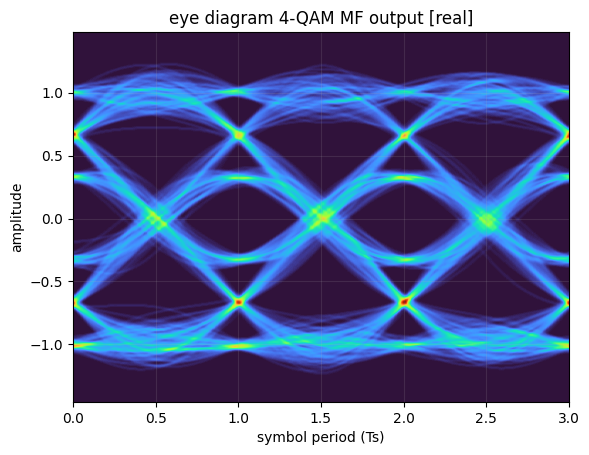

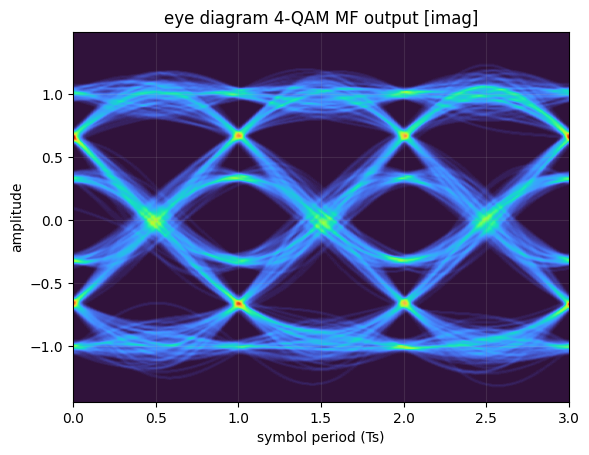

In [166]:
# parâmetros da simulação
SpS = 4             # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

M = 4  # ordem do formato de modulação
constType = 'qam'

# Simulação de transmissão em canal AWGN
SNRdB = 30  # relação sinal-ruído em dB

# parâmetros do canal linear
hch = np.array([0.207, 0.815, 0.207]) # resposta ao impulso do canal
hch_up = upsample(hch, SpS)

# Define constelação
constSymb = GrayMapping(M, constType)
Es = np.mean(np.abs(constSymb**2))

constSymb = pnorm(constSymb)

# gera sequência de bits pseudo-aleatória
bitsTx = np.random.randint(2, size = int(200000*np.log2(M)))

# gera sequência de símbolos da modulação
symbTx = modulateGray(bitsTx, M, constType)
symbTx = pnorm(symbTx) # normaliza energia média dos símbolos

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso NRZ
pulse = pulseShape('rrc', SpS,  N=2048, alpha=0.01)
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# canal linear
sigCh = firFilter(hch_up, sigTx)
sigCh = pnorm(sigCh)

# ruído gaussiano branco
Nsamples = sigTx.size
σ2 = 1/(10**(SNRdB/10))
σ  = np.sqrt(σ2*SpS)

if constType == 'pam':
    ruido  = np.random.normal(0, σ, Nsamples) # real-valued AWGN
elif constType == 'qam':
    ruido  = 1/np.sqrt(2)*(np.random.normal(0, σ, Nsamples) + 1j*np.random.normal(0, σ, Nsamples)) # complex-valued AWGN

# filtro casado
sigRx = firFilter(pulse, sigCh+ruido)
sigRx = pnorm(sigRx)

# diagrama de olho após o filtro casado
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' MF output', ptype='fancy')

### Constelação com presença de ISI

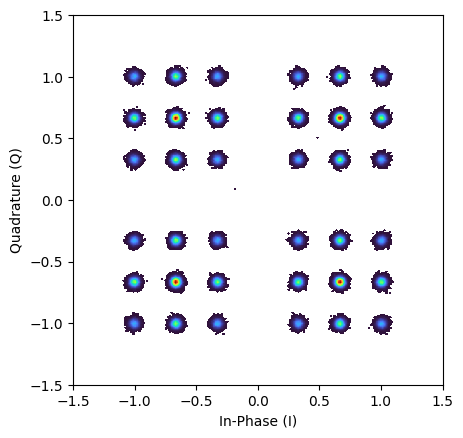

In [167]:
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
const = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

pconst(const, R=1.5);

### Após a equalização

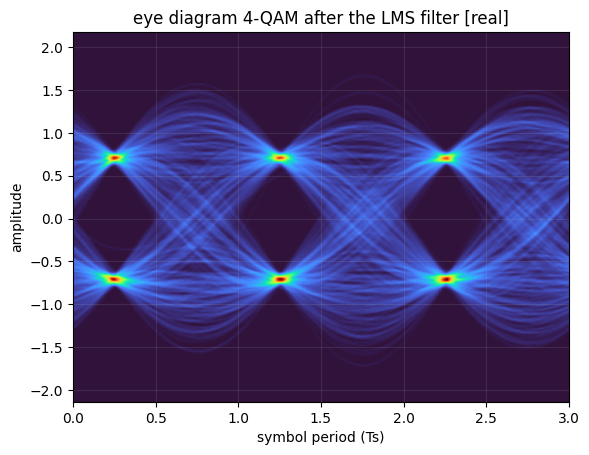

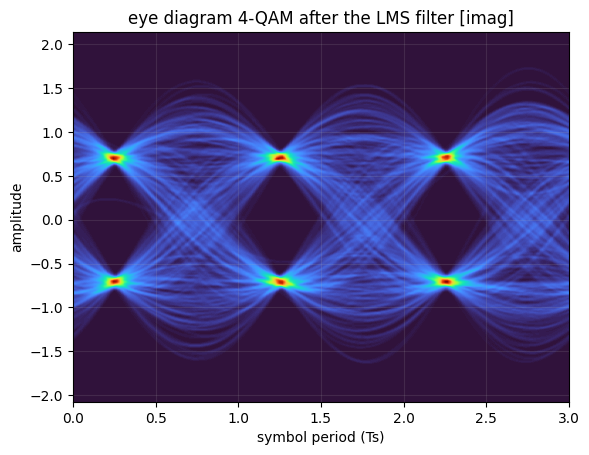

In [168]:
# downsampling
y = sigRx[0::SpS]
y = pnorm(y)

# parâmetros do equalizador
Ntaps = 12
mu = 0.005

# equalizador LMS
symbRx, erro, squaredError, h_eq = lms(y, symbTx, Ntaps, mu)
symbRx = pnorm(symbRx)

# aplicando o filtro obtido pelo equalizador LMS no sinal obtido na saída do filtro casado
sigLMS = firFilter(upsample(h_eq, SpS), firFilter(pulse, sigCh+ruido))

# observando o diagrama de olho como se o filtro obtido pelo equalizador LMS já fosse conhecido e aplicado diretamente na saída do filtro casado
eyediagram(pnorm(sigLMS), Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' after the LMS filter', ptype='fancy')

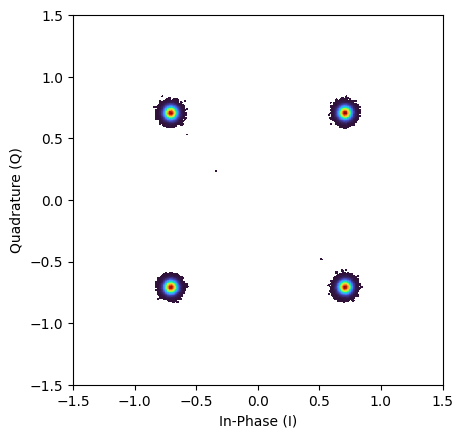

In [169]:
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
const = decimate(sigLMS.reshape(-1,1), paramDec).reshape(-1,)

pconst(const, R=1.5);

# plt.figure()
# plt.ylim(-250,-50)
# plt.xlim(-0.40, 0.40)
# plt.psd(sigLMS, Fs=2*Rs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal equalizado')
# plt.legend(loc='upper left')
# plt.xlim(-Rs, Rs);

### Remoção de ISI

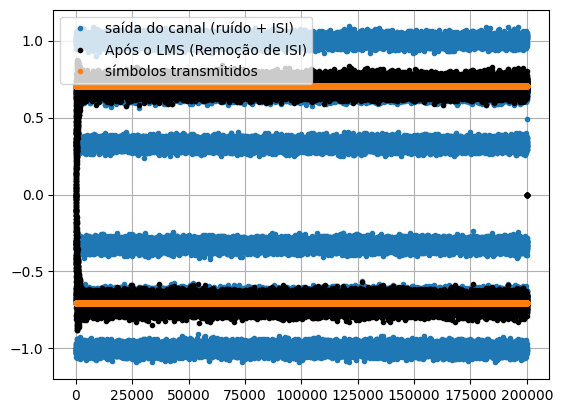

In [170]:
plt.plot(y,'.', label='saída do canal (ruído + ISI)');
plt.plot(symbRx,'k.', label='Após o LMS (Remoção de ISI)');
plt.plot(symbTx,'.',  label='símbolos transmitidos');
plt.legend(loc='upper left');
plt.grid();

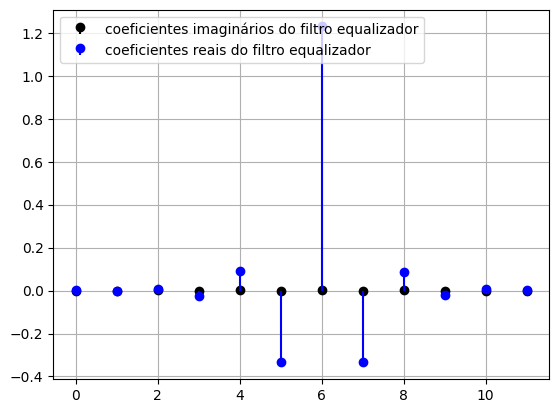

In [171]:
plt.figure()
plt.stem(h_eq.imag, 'black', basefmt=" ", label='coeficientes imaginários do filtro equalizador')
plt.stem(h_eq.real, 'b', basefmt=" ", label='coeficientes reais do filtro equalizador')
plt.grid()
plt.legend(loc='upper left');

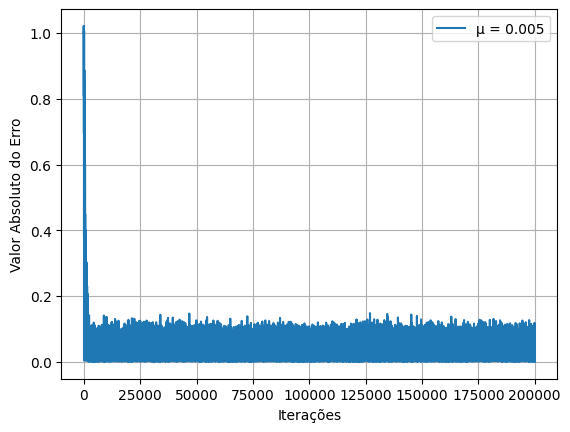

In [172]:
plt.plot(np.abs(erro), label=f'µ = {mu}')
plt.grid()
plt.ylabel('Valor Absoluto do Erro')
plt.xlabel('Iterações')
plt.legend();

### Exemplo utilizando LMS para compersar a CD

Potência média do sinal óptico modulado [mW]: 1.190 mW
Potência média do sinal óptico modulado [dBm]: 0.757 dBm

Constelação na saída do front-end coerente:


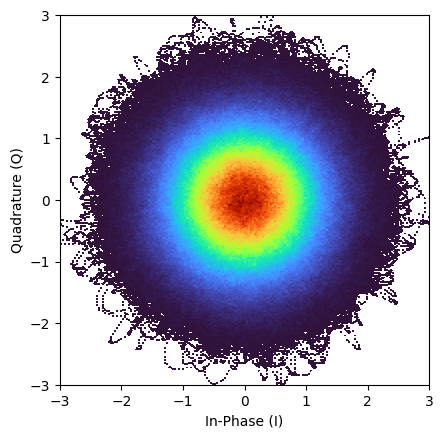

Constelação na saída do filtro casado:


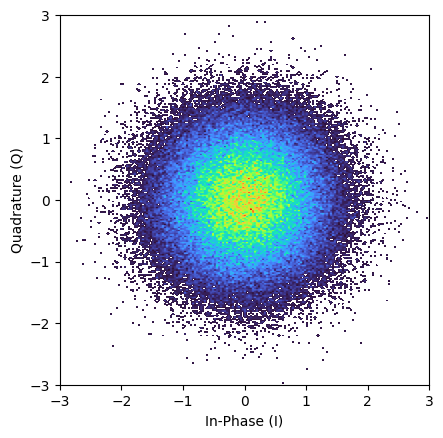

Constelação após a equalização:


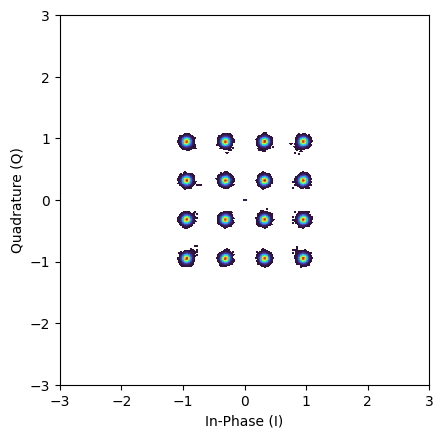

In [52]:
### Transmissor ###
M = 16                  # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rrc'       # Pulso a ser utilizado
Rs = 30e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]

### formatação de pulso ###

plotPSD = False

# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # symbol power normalization

symbolsUp = upsample(symbTx, SpS)

if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rrc":
    pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Front-End Óptico ###

# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# parâmetros do receptor
B = 30e9            # banda do receptor em Hz
Plo_dBm  = 10       # potência do oscilador local
Δf_lo    = 0        # desvio de frequência do oscilador local
ϕ_lo     = 0        # fase do oscilador local
lw       = 100      # laser linewidth Hz

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# sinal na saída do front-end do receptor coerente
print('\nConstelação na saída do front-end coerente:')
sigRx_ = coherentReceiver(sigRxo, sigLO)
pconst(sigRx_, R=3);

# filtro casado
print('Constelação na saída do filtro casado:')
sigRx = firFilter(pulse, sigRx_)
pconst(sigRx[0::SpS], R=3)

### Equalização adaptativa usando LMS ###

# downsampling
y = sigRx[0::SpS]
y = pnorm(y)

# parâmetros do equalizador
Ntaps = 24
mu = 2e-3

# equalizador LMS
symbRx, erro, squaredError, h_eq = lms(y, symbTx, Ntaps, mu)
symbRx = pnorm(symbRx)

print('Constelação após a equalização:')

# remova o transiente das primeiras iterações do LMS descartando amostras iniciais
discard = 1000
pconst(symbRx[discard:], R=3);

### Constant Modulus Algorithm (CMA)

Nesta etapa iremos explorar o algoritmo CMA, o mesmo pode ser utilizado para recuperação de relógio (*clock recovery*) ou até mesmo para separar sinais multiplexados em diferentes estados de polarização, porém o nosso foco principal é realizar a equalização adaptativa, desfazendo as possíveis distorções introduzidas pelo canal. Assim iremos tentar fazer com que o canal pareça um canal passa-tudo.

Diferente do algoritmo LMS o CMA é um método cego para equalização, quando fazemos métodos cegos de adaptação sem conhecimento da sequência de treinamento frequentemente usamos uma descida estocástica que adaptativamente encontra os coeficientes ótimos para o filtro linear, uma equalização cega, não há sequência de treinamento necessária, os sistemas cegos exploram algumas características do formato de modulação. Em particular as características do esquema de modulação que estamos procurando possuem módulo constante, então qpsk é um excelente exemplo de uma modulação para formato com um módulo constante porque qpsk tem a mesma potência para todos os símbolos que são transmitidos, todos são transmitidos na mesma potência, o que distingue um símbolo de outro em qpsk é a fase desse símbolo, mas a amplitude é a mesma para todos eles, então o módulo é o mesmo.

Dessa forma o algoritmo, ao forçar o sinal recebido a ter um módulo constante, está corrigindo os efeitos de limitação de largura de banda e está neutralizando algo como interferência intersimbólica, de modo que quando meu sinal passa por um canal com largura de banda limitada, ele criará uma dispersão do pulso que levará à sobreposição causando ISI que consequêntemente deteriorará o desempenho do meu sistema de comunicação, então o algoritmo de módulo constante é uma maneira de fazer equalização para mitigar esse efeito.

### Implementação do equalizador CMA

Esta implementação está descrita no livro de referência [Adaptive Filtering Algorithms and Practical Implementation](https://link.springer.com/chapter/10.1007/978-0-387-68606-6_13) em forma de pseudo código. 

In [53]:
def cma(u, constSymb, taps, mu):
    """ Constant-Modulus Algorithm

    Implementação do equalizador de módulo constante.

    Args:
        u (np.array)        : sinal de entrada unidimensional
        constSymb (np.array): símbolos da constelação
        taps (int)          : número de coeficientes do filtro   
        mu (float)          : tamanho do passo para o CMA

    Returns:
        tuple: 
            - np.array: sinal de saída.
            - np.array: sinal de erro.
            - np.array: coeficintes do filtro após a convergência.
    
    Referências:
        [1] Adaptive Filtering: Algorithms and Practical Implementation
    """

    # Constante relacionada às características da modulação.
    R = np.mean(np.abs(constSymb)**4) / np.mean(np.abs(constSymb)**2)
    
    # Número de iterações para filtragem adaptativa
    N = len(u) - taps + 1
    
    # Obtém o atraso da filtragem FIR
    delay = (taps - 1) // 2

    y = np.zeros(len(u), dtype='complex')  # saída do filtro
    e = np.zeros(len(u), dtype='complex')  # sinal de erro

    # Inicialização dos coeficientes do filtro
    w = np.zeros(taps, dtype='complex')
    w[delay] = 1  

    # Executa a filtragem adaptativa
    for n in range(N):
        
        # janela deslizante correspondente à ordem do filtro
        x = np.flipud(u[n:n + taps])

        # calcula a saída no instante n
        y[n] = np.dot(w, x)
        
        # calcula o erro
        e[n] = y[n] * (np.abs(y[n])**2 - R)
        
        # calcula os novos coeficientes do filtro
        w -= 2 * mu * e[n] * np.conj(x)
    
    return y, e, w

### Utilizando o equalizador CMA para mitigar a ISI

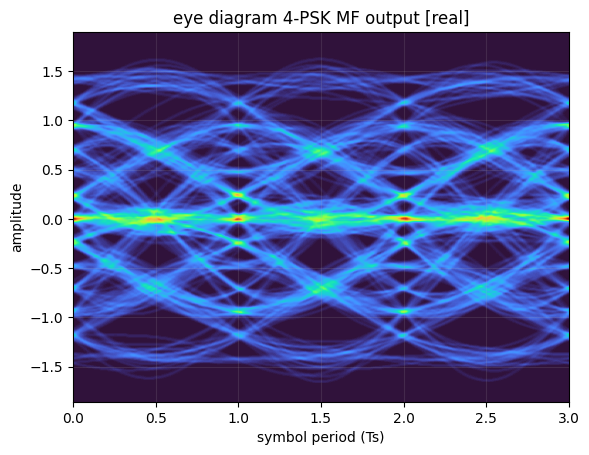

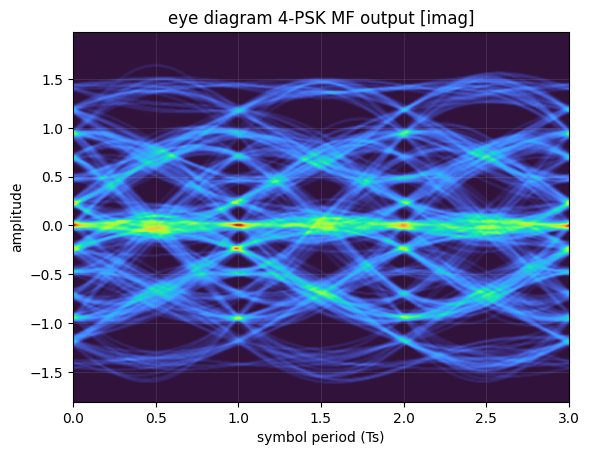

In [175]:
# parâmetros da simulação
SpS = 4             # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

M = 4  # ordem do formato de modulação
constType = 'psk'

# Simulação de transmissão em canal AWGN
SNRdB = 30  # relação sinal-ruído em dB

# parâmetros do canal linear
hch = np.array([0.207, 0.815, 0.207]) # resposta ao impulso do canal
hch_up = upsample(hch, SpS)

# Define constelação
constSymb = GrayMapping(M, constType)
Es = np.mean(np.abs(constSymb**2))

constSymb = pnorm(constSymb)

# gera sequência de bits pseudo-aleatória
bitsTx = np.random.randint(2, size = int(200000*np.log2(M)))

# gera sequência de símbolos da modulação
symbTx = modulateGray(bitsTx, M, constType)
symbTx = pnorm(symbTx) # normaliza energia média dos símbolos

# upsampling
symbolsUp = upsample(symbTx, SpS)

# formatação de pulso NRZ
pulse = pulseShape('rrc', SpS,  N=2048, alpha=0.01)
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# canal linear
sigCh = firFilter(hch_up, sigTx)
sigCh = pnorm(sigCh)

# ruído gaussiano branco
Nsamples = sigTx.size
σ2 = 1/(10**(SNRdB/10))
σ  = np.sqrt(σ2*SpS)

if constType == 'pam':
    ruido  = np.random.normal(0, σ, Nsamples) # real-valued AWGN
elif constType == 'qam':
    ruido  = 1/np.sqrt(2)*(np.random.normal(0, σ, Nsamples) + 1j*np.random.normal(0, σ, Nsamples)) # complex-valued AWGN

# filtro casado
sigRx = firFilter(pulse, sigCh+ruido)
sigRx = pnorm(sigRx)

# diagrama de olho após o filtro casado
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' MF output', ptype='fancy')

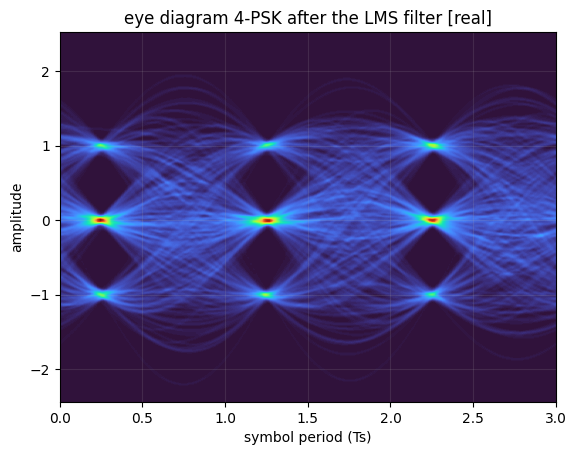

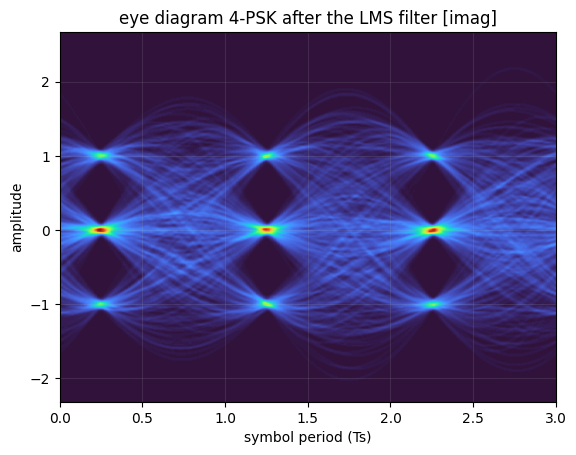

In [176]:
# downsampling
y = sigRx[0::SpS]
y = pnorm(y)

# parâmetros do equalizador
Ntaps = 16
mu = 0.001

# equalizador CMA
symbRx, erro, h_eq = cma(y, symbTx, Ntaps, mu)
symbRx = pnorm(symbRx)

# aplicando o filtro obtido pelo equalizador LMS no sinal obtido na saída do filtro casado
sigCMA = firFilter(upsample(h_eq, SpS), firFilter(pulse, sigCh+ruido))

# observando o diagrama de olho como se o filtro obtido pelo equalizador LMS já fosse conhecido e aplicado diretamente na saída do filtro casado
eyediagram(pnorm(sigCMA), Nsamples, SpS, plotlabel= str(M)+'-'+constType.upper()+' after the LMS filter', ptype='fancy')

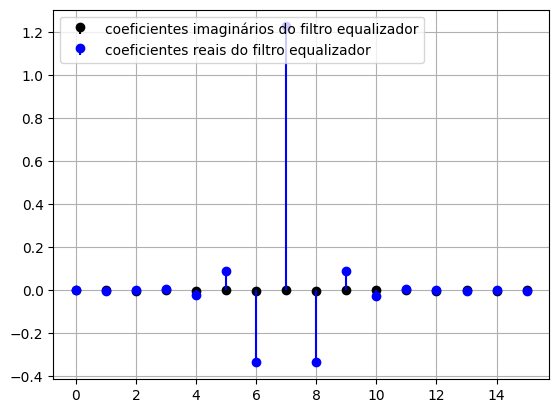

In [177]:
plt.figure()
plt.stem(h_eq.imag, 'black', basefmt=" ", label='coeficientes imaginários do filtro equalizador')
plt.stem(h_eq.real, 'b', basefmt=" ", label='coeficientes reais do filtro equalizador')
plt.grid()
plt.legend(loc='upper left');

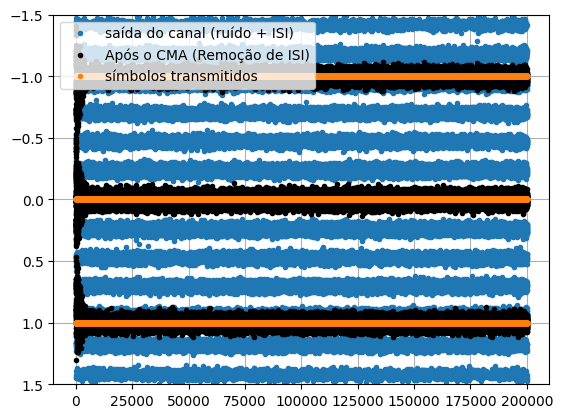

In [178]:
plt.plot(y,'.', label='saída do canal (ruído + ISI)');
plt.plot(symbRx,'k.', label='Após o CMA (Remoção de ISI)');
plt.plot(symbTx,'.',  label='símbolos transmitidos');
plt.ylim(1.5,-1.5)
plt.legend(loc='upper left');
plt.grid();

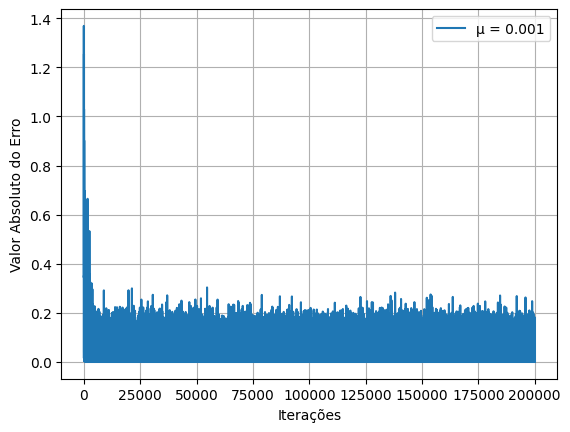

In [179]:
plt.plot(np.abs(erro), label=f'µ = {mu}')
plt.grid()
plt.ylabel('Valor Absoluto do Erro')
plt.xlabel('Iterações')
plt.legend();

### Exemplo utilizando o equalizador CMA para compensação de CD 

Observe que a simulação utiliza um esquema de modulação de módulo constante PSK, visto que o algoritmo CMA se aproveita desta característica para uma equalização cega, forçando o sinal recebido a ter um módulo constante.

Potência média do sinal óptico modulado [mW]: 1.191 mW
Potência média do sinal óptico modulado [dBm]: 0.758 dBm

Constelação na saída do front-end coerente:


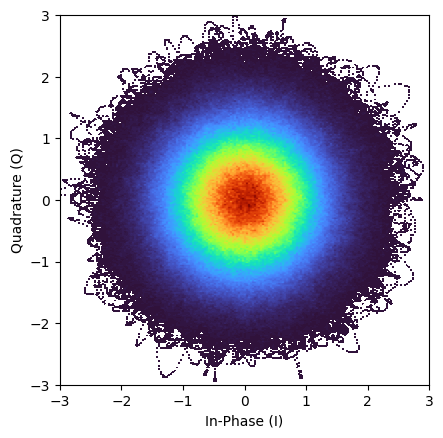

Constelação na saída do filtro casado:


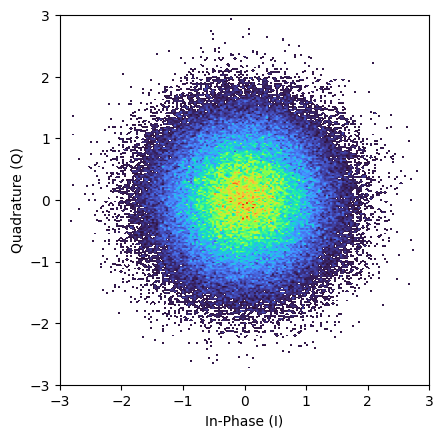

Constelação após a equalização:


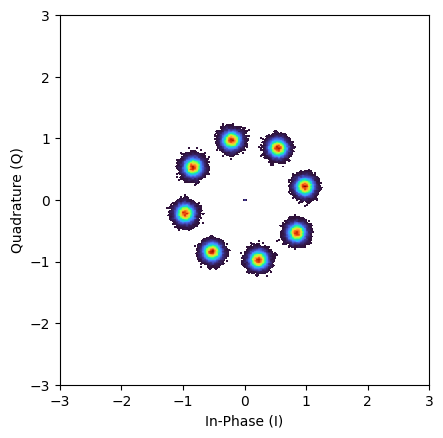

In [56]:
### Transmissor ###
M = 8                  # Ordem da modulação
constType = 'psk'       # Esquema de modulação
pulseType = 'rrc'       # Pulso a ser utilizado
Rs = 32e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# Parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]

### formatação de pulso ###

plotPSD = False

# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # symbol power normalization

symbolsUp = upsample(symbTx, SpS)

if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rrc":
    pulse = pulseShape("rrc", SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = iqm(Ai, 0.1*paramIQM.Vπ*sigTx, paramIQM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

### Front-End Coerente ###

# parâmetros do receptor
B = 32e9            # banda do receptor em Hz
Plo_dBm  = 10       # potência do oscilador local
Δf_lo    = 0        # desvio de frequência do oscilador local
ϕ_lo     = 0        # fase do oscilador local
lw       = 100      # laser linewidth Hz

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# sinal na saída do front-end do receptor coerente
print('\nConstelação na saída do front-end coerente:')
sigRx_ = coherentReceiver(sigRxo, sigLO)
pconst(sigRx_, R=3);

# filtro casado
print('Constelação na saída do filtro casado:')
sigRx = firFilter(pulse, sigRx_)
pconst(sigRx[0::SpS], R=3)

### Equalização adaptativa usando CMA ###

# downsampling
y = sigRx[0::SpS]
y = pnorm(y)

# parâmetros do equalizador
Ntaps = 24
mu = 2e-3

# equalizador CMA
symbRx, erro, h_eq, = cma(y, symbTx, Ntaps, mu)
symbRx = pnorm(symbRx)

print('Constelação após a equalização:')

# remova o transiente das primeiras iterações do CMA descartando amostras iniciais
discard = 4000
pconst(symbRx[discard:], R=3);

### Equalização Adaptativa em Sistemas Polarizados-Multiplexados    

In [266]:
@njit
def cmaUp(x, R, taps, lr, indN):
    """ Constant-Modulus Algorithm

    Implementação do algoritmo de módulo constante para 
    multiplexação de polarização.

    Args:
        x (np.array): sinal de entrada de duas colunas.
        R (int)     : constante relacionada às características da modulação.
        taps (int)  : número de coeficientes do filtro.
        lr (float)  : tamanho do passo para a convergência do CMA.
        indN (int)  : número de cálculos de coeficientes a serem realizados antes da inicialização
                      adequada dos filtros w2H e w2V

    Raises:
        ValueError: caso o sinal não possua 2 modos de polarização.

    Returns:
        tuple:
            - y (np.array): estimativa dos símbolos.
            - e (np.array): erro associado a cada modo de polarização.
            - w (np.array): matriz de coeficientes.
    
    Referências:
        [1] Digital Coherent Optical Systems, Architecture and Algorithms
    """
    
    if x.shape[1] != 2:
        raise ValueError("O sinal deve conter duas polarizações")

    nModes = x.shape[1]

    N = len(x) - taps + 1

    # Obtém o atraso da filtragem FIR
    delay = (taps - 1) // 2

    y = np.zeros((len(x), nModes), dtype='complex')
    e = np.zeros((len(x), nModes), dtype='complex') 
    w = np.zeros((taps, nModes**2), dtype='complex')
    
    # single spike initialization
    w[:,0][delay] = 1
    #w[:,2][delay] = 1
    
    for n in range(N):

        xH = np.flipud(x[:,0][n:n+taps])
        xV = np.flipud(x[:,1][n:n+taps])

        # calcula a saída do equalizador 2x2
        y[:,0][n] = np.dot(w[:,0], xV) + np.dot(w[:,1], xH)
        y[:,1][n] = np.dot(w[:,2], xV) + np.dot(w[:,3], xH)

        # calcula o erro
        e[:,0][n] = y[:,0][n] * (R - np.abs(y[:,0][n])**2)
        e[:,1][n] = y[:,1][n] * (R - np.abs(y[:,1][n])**2)

        # atualiza os coeficientes do filtro
        w[:,0] += lr * np.conj(xV) * e[:,0][n]
        w[:,2] += lr * np.conj(xV) * e[:,1][n]
        w[:,1] += lr * np.conj(xH) * e[:,0][n]
        w[:,3] += lr * np.conj(xH) * e[:,1][n]

        if n == indN:
            w[:,3] =  np.conj(w[:,0][::-1])
            w[:,2] = -np.conj(w[:,1][::-1])

    return y, e, w

### Simulação WDM 32G PM-4PSK

In [272]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 4                  # order of the modulation format
paramTx.constType = "psk"      # modulation scheme
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Nmodes = 2             # number of signal modes [2 for polarization multiplexed signals]
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

## fiber parameters:
paramFiber = parameters()
paramFiber.L = 100          # comprimento do enlace [km]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 17           # parâmetro de dispersão [ps/nm/km]
paramFiber.Fs = Fs          # Frequência de amostragem do sinal [amostras/segundo]

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linearFiberChannel(sigWDM_Tx, paramFiber)

  0%|          | 0/1 [00:00<?, ?it/s]

### Plot PSD

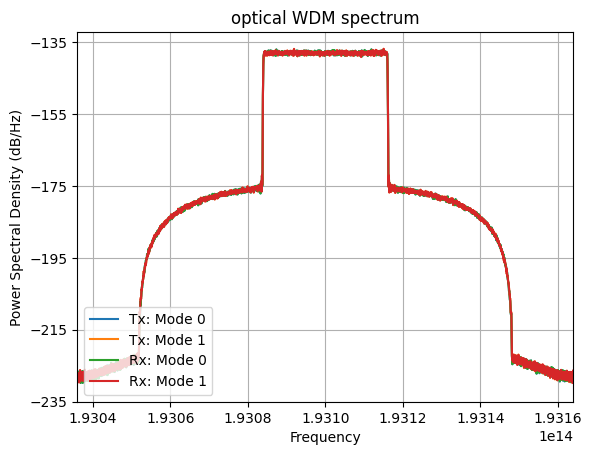

In [273]:
# plot psd
fig,_ = plotPSD(sigWDM_Tx, Fs, paramFiber.Fc, label='Tx'); 
fig, ax = plotPSD(sigCh, Fs, paramFiber.Fc, fig=fig, label='Rx');
ax.set_title('optical WDM spectrum');

### Demodulação e Detecção Coerente

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 150.00 MHz



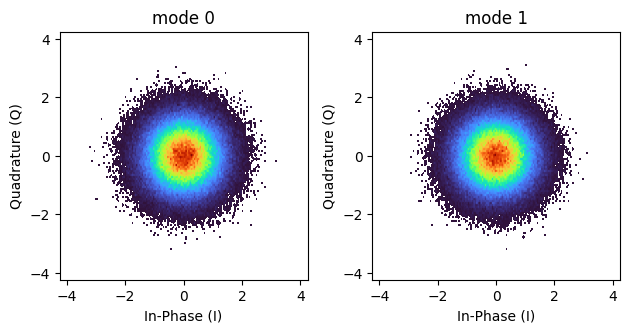

In [274]:
# parameters
chIndex = 0  # index of the channel to be demodulated

Fc = paramTx.Fc
Ts = 1/Fs
freqGrid = paramTx.freqGrid
π  = np.pi
t  = np.arange(0, len(sigCh))*Ts

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigCh)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver

# photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs    
paramPD.ideal = True

# sigRx_ = coherentReceiver(sigCh, sigLO)

θsig = π/3 # polarization rotation angle
sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig, paramPD)

# plot received constellations
pconst(sigRx[0::paramTx.SpS], R=3);

### Filtragem correspondente

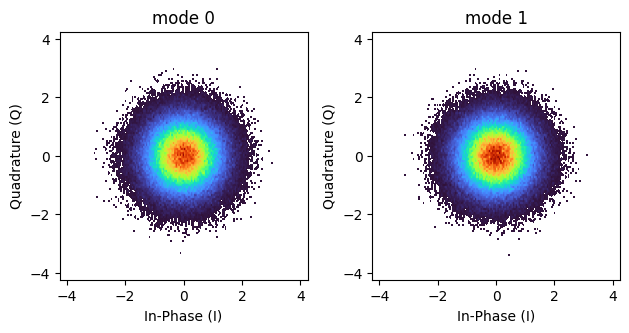

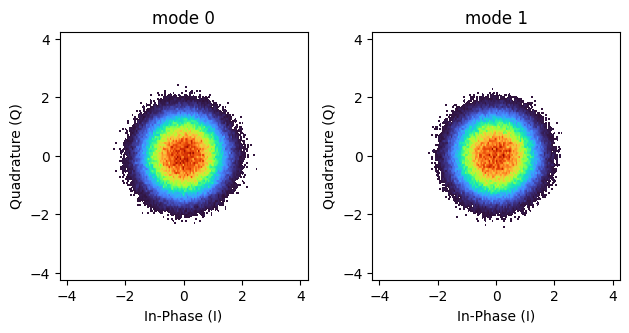

(<Figure size 640x480 with 2 Axes>,
 <ScatterDensityAxes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [275]:
# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pnorm(pulse)
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], R=3) 

# CD compensation
paramEDC = parameters()
paramEDC.L = paramFiber.L
paramEDC.D = paramFiber.D
paramEDC.Fc = Fc-Δf_lo
paramEDC.Fs = Fs

sigRx = edc(sigRx, paramEDC)
pconst(sigRx[0::paramTx.SpS,:], R=3) 

(200000, 2)


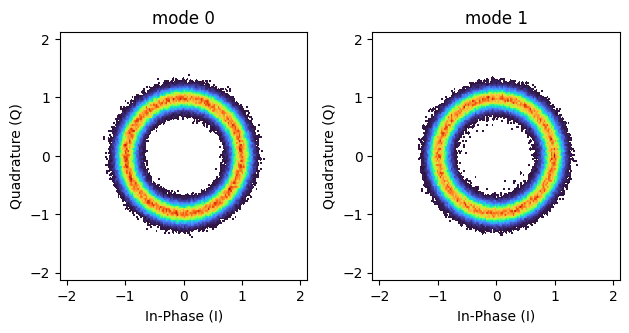

(<Figure size 640x480 with 2 Axes>,
 <ScatterDensityAxes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [276]:
x = sigRx[0::paramTx.SpS,:]
x = pnorm(x)

# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

symbRx = symbolSync(sigRx, symbTx, 2)
symbRx = pnorm(symbRx)

R = np.mean(np.abs(symbRx)**4) / np.mean(np.abs(symbRx)**2)
taps = 15
lr = 2e-3
N  = 4000
y_EQ, Error, W = cmaUp(x, R, taps, lr, N)

print(y_EQ.shape)

discard = 5000
pconst(y_EQ[discard:-discard,:], R=1.5) 

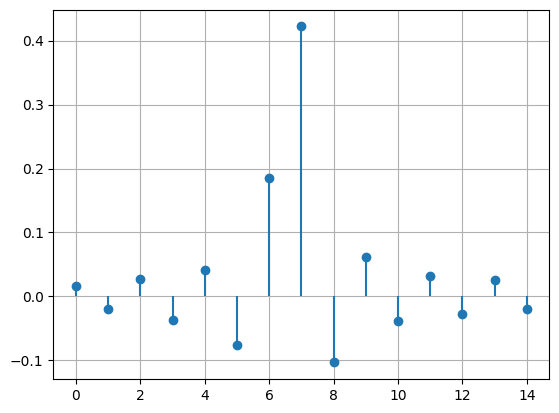

In [278]:
plt.stem(W[:, 1].real, basefmt=" ")
#plt.stem(W[:, 3].imag, basefmt=" ")
plt.grid()

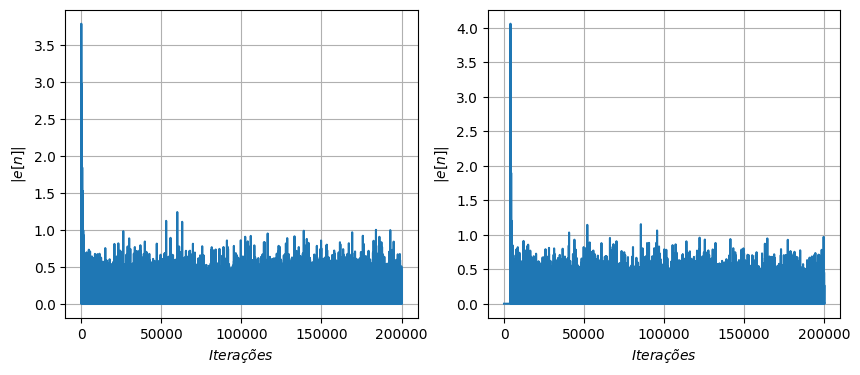

In [279]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.abs(Error[:, 0].real), label='Mode 0')
axs[0].set_ylabel(r'$|e{[n]}|$')
axs[0].set_xlabel(r'$Iterações$')
axs[0].grid(True)

axs[1].plot(np.abs(Error[:, 1].real), label='Mode 1')
axs[1].set_ylabel(r'$|e{[n]}|$')
axs[1].set_xlabel(r'$Iterações$')
axs[1].grid(True)

In [270]:
from optic.dsp.carrierRecovery import cpr

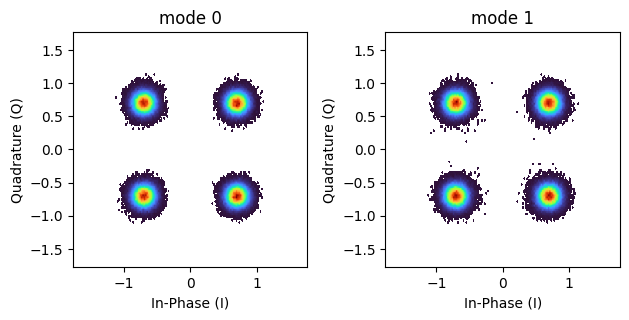

In [280]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 75
paramCPR.B   = 64

y_CPR = cpr(y_EQ, paramCPR)

discard = 5000
#plot constellations after CPR
pconst(y_CPR[discard:-discard,:]);

In [ ]:
"""
xH = sigRx[:,0]
xV = sigRx[:,1]

w1V ==> w[:,0]
w1H ==> w[:,1]
w2V ==> w[:,2]
w2H ==> w[:,3]

"""

# Referências

[1] Digital Coherent Optical Systems, Architecture and Algorithms

[[2]](https://arxiv.org/pdf/1603.00734.pdf) T. Xu, G. Jacobsen, S. Popov, M. Forzati, J. Mårtensson, M. Mussolin, J. Li, K. Wang, Y. Zhang, A.T. Friberg, Frequency-domain chromatic dispersion equalization using overlap-add methods in coherent optical system. J. Opt. Commun. 32(2), 131–135 (2011)

[3] Processamento Digital de Sinais Paulo S. R. Diniz Eduardo A. B. da Silva Sergio L. Netto Projeto e Análise de Sistemas. 2º Ed.

[4] Paulo S. R. Diniz (auth.) - Adaptive Filtering Algorithms and Practical Implementation Springer US (2008)